### 安裝環境

In [15]:
import os

os.environ["GIT_CLONE_PROTECTION_ACTIVE"] = "false"

# %pip install -q "nncf>=2.11.0"
# %pip install -Uq "openvino>=2024.3.0"
# %pip install -q "git+https://github.com/THU-MIG/yolov10.git" --extra-index-url https://download.pytorch.org/whl/cpu
# %pip install -q "torch>=2.1" "torchvision>=0.16" tqdm opencv-python "gradio>=4.19" --extra-index-url https://download.pytorch.org/whl/cpu

### 導入操作工具

In [16]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, VideoPlayer

### 導入模型

In [17]:
models_dir = Path("./models")
models_dir.mkdir(exist_ok=True)

In [18]:
model_weights_url = "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt"
file_name = model_weights_url.split("/")[-1]
model_name = file_name.replace(".pt", "")

download_file(model_weights_url, directory=models_dir)

'models\yolov10n.pt' already exists.


WindowsPath('C:/Users/User/Documents/FCU_LabVIEW_Course_AI_part/MachineLearning/models/yolov10n.pt')

### 將pt匯出為ov 模型

In [19]:
import types
from ultralytics.utils import ops, yaml_load, yaml_save
from ultralytics import YOLOv10
import torch

detection_labels = {
    0: "person",
    1: "bicycle",
    2: "car",
    3: "motorcycle",
    4: "airplane",
    5: "bus",
    6: "train",
    7: "truck",
    8: "boat",
    9: "traffic light",
    10: "fire hydrant",
    11: "stop sign",
    12: "parking meter",
    13: "bench",
    14: "bird",
    15: "cat",
    16: "dog",
    17: "horse",
    18: "sheep",
    19: "cow",
    20: "elephant",
    21: "bear",
    22: "zebra",
    23: "giraffe",
    24: "backpack",
    25: "umbrella",
    26: "handbag",
    27: "tie",
    28: "suitcase",
    29: "frisbee",
    30: "skis",
    31: "snowboard",
    32: "sports ball",
    33: "kite",
    34: "baseball bat",
    35: "baseball glove",
    36: "skateboard",
    37: "surfboard",
    38: "tennis racket",
    39: "bottle",
    40: "wine glass",
    41: "cup",
    42: "fork",
    43: "knife",
    44: "spoon",
    45: "bowl",
    46: "banana",
    47: "apple",
    48: "sandwich",
    49: "orange",
    50: "broccoli",
    51: "carrot",
    52: "hot dog",
    53: "pizza",
    54: "donut",
    55: "cake",
    56: "chair",
    57: "couch",
    58: "potted plant",
    59: "bed",
    60: "dining table",
    61: "toilet",
    62: "tv",
    63: "laptop",
    64: "mouse",
    65: "remote",
    66: "keyboard",
    67: "cell phone",
    68: "microwave",
    69: "oven",
    70: "toaster",
    71: "sink",
    72: "refrigerator",
    73: "book",
    74: "clock",
    75: "vase",
    76: "scissors",
    77: "teddy bear",
    78: "hair drier",
    79: "toothbrush",
}


def v10_det_head_forward(self, x):
    one2one = self.forward_feat([xi.detach() for xi in x], self.one2one_cv2, self.one2one_cv3)
    if not self.export:
        one2many = super().forward(x)

    if not self.training:
        one2one = self.inference(one2one)
        if not self.export:
            return {"one2many": one2many, "one2one": one2one}
        else:
            assert self.max_det != -1
            boxes, scores, labels = ops.v10postprocess(one2one.permute(0, 2, 1), self.max_det, self.nc)
            return torch.cat(
                [boxes, scores.unsqueeze(-1), labels.unsqueeze(-1).to(boxes.dtype)],
                dim=-1,
            )
    else:
        return {"one2many": one2many, "one2one": one2one}


ov_model_path = models_dir / f"{model_name}_openvino_model/{model_name}.xml"
if not ov_model_path.exists():
    model = YOLOv10(models_dir / file_name)
    model.model.model[-1].forward = types.MethodType(v10_det_head_forward, model.model.model[-1])
    model.export(format="openvino", dynamic=True, half=True)
    config = yaml_load(ov_model_path.parent / "metadata.yaml")
    config["names"] = detection_labels
    yaml_save(ov_model_path.parent / "metadata.yaml", config)

### 導入圖片

In [20]:
from PIL import Image

# IMAGE_PATH = Path("./data/coco_bike.jpg")
# IMAGE_PATH = Path("./data/grape.jpg")
IMAGE_PATH = Path("./data/duck_dog.jpg")
download_file(
    # url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg",
    # url="https://secure-res.craft.do/v2/N24q8sUxWcjN6pxDbbPcoKnPjszkw3JcLn6Q83wn92BQzRxh22rZgnyCxsprxHsmTP96RDJCyrHZqU7zatJ1JMYB1hJEWwo59XXTsn6P5DYSRPus56u1579WE3AGKPazVL5MgGn5bgKbpUMBXfJFauS1fKzXyLnYjzXmhgvJD3RGd9W/IMG_5343.jpg",
    url="https://secure-res.craft.do/v2/N24q8sUxWcjN6pxDbbPcoKnPjszkw3JcLn6Q83wn92BQzRxh22rZgnyCxsprxHsmTP96RDJCyrHZqU7zatJ1JMYB1hJEWwo59XXTsn6P5DYSRSwwTwMsTmzf98CWHaSKQ8x7fJrzWFTwput3Sv5zn9yHduhWECwRQjKrNpEr1H1zjY9/IMG_5555.jpg",
    filename=IMAGE_PATH.name,
    directory=IMAGE_PATH.parent,
)

'data\duck_dog.jpg' already exists.


WindowsPath('C:/Users/User/Documents/FCU_LabVIEW_Course_AI_part/MachineLearning/data/duck_dog.jpg')

### 設置使用模型

In [21]:
# OpenVINO
ov_yolo_model = YOLOv10(ov_model_path.parent, task="detect")

In [22]:
# torch
TORCH_MODEL = r"C:\Users\User\Documents\openvino_notebooks\notebooks\yolov10-optimization\models\yolov10n.pt"
torch_yolo_model = YOLOv10(TORCH_MODEL, task="detect")

### Run torch(auto device)


image 1/1 c:\Users\User\Documents\FCU_LabVIEW_Course_AI_part\MachineLearning\data\duck_dog.jpg: 640x640 1 14, 1 16, 32.0ms
Speed: 4.0ms preprocess, 32.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


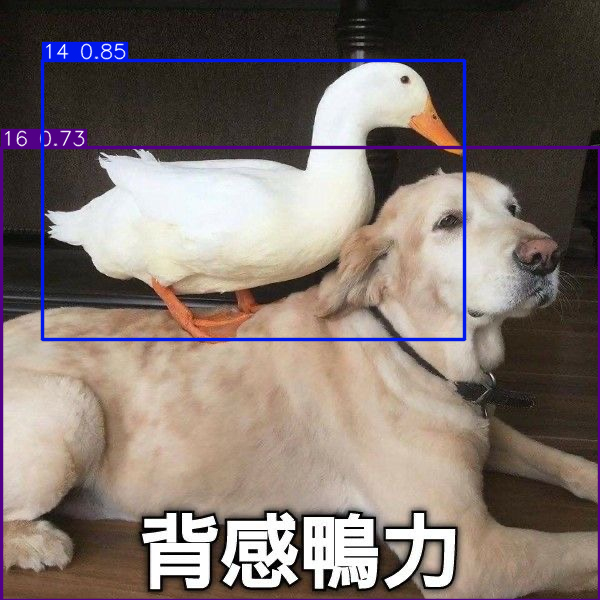

In [23]:
# res_torch = torch_yolo_model(IMAGE_PATH, iou=0.45, conf=0.2)
# IMAGE_PATH = Path(r"C:\Users\User\Pictures\iCloud Photos\Photos\IMG_5555.JPG")
res_torch = torch_yolo_model(IMAGE_PATH, iou=0.45, conf=0.2)
Image.fromarray(res_torch[0].plot()[:, :, ::-1])

### Run ov (select device)

In [24]:
import openvino as ov

import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="CPU",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU', 'AUTO'), value='CPU')

In [25]:
ov_model = core.read_model(ov_model_path)

# load model on selected device
if "GPU" in device.value or "NPU" in device.value:
    ov_model.reshape({0: [1, 3, 640, 640]})
ov_config = {}
if "GPU" in device.value:
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
det_compiled_model = core.compile_model(ov_model, device.value, ov_config)

In [26]:
# ov_yolo_model.predictor.model.ov_compiled_model = det_compiled_model

Loading models\yolov10n_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 c:\Users\User\Documents\FCU_LabVIEW_Course_AI_part\MachineLearning\data\duck_dog.jpg: 640x640 1 bird, 1 dog, 42.2ms
Speed: 3.0ms preprocess, 42.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


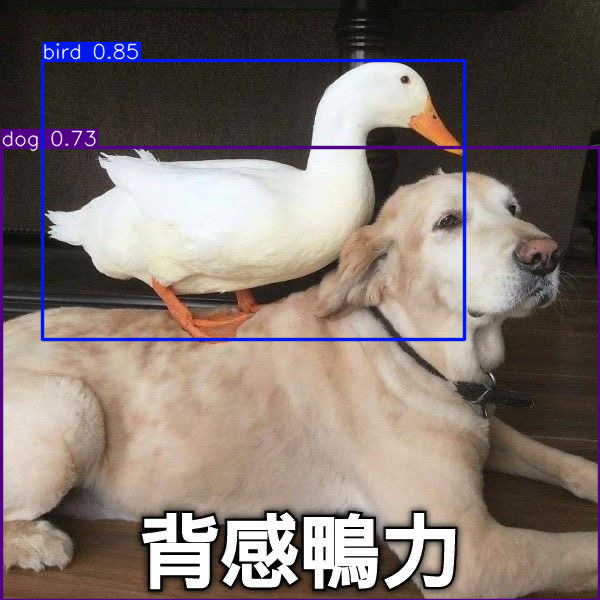

In [27]:
res = ov_yolo_model(IMAGE_PATH, iou=0.45, conf=0.2)
Image.fromarray(res[0].plot()[:, :, ::-1])

Loading models\yolov10n_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 c:\Users\User\Documents\FCU_LabVIEW_Course_AI_part\MachineLearning\data\grape.jpg: 640x640 20 apples, 2 oranges, 108.5ms
Speed: 7.0ms preprocess, 108.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


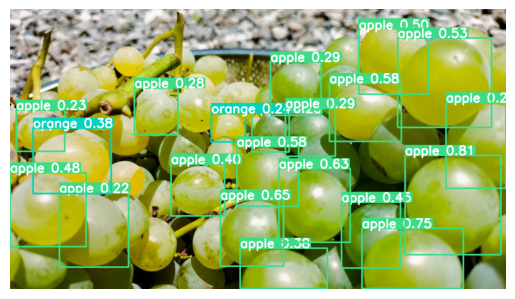

In [28]:
from pathlib import Path
import requests
import types
from ultralytics.utils import ops, yaml_load, yaml_save
from ultralytics import YOLOv10
import torch
from PIL import Image
import matplotlib.pyplot as plt

def main_inference(image_path: Path):
    models_dir = Path("./models")
    models_dir.mkdir(exist_ok=True)

    model_weights_url = "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt"
    file_name = model_weights_url.split("/")[-1]
    model_name = file_name.replace(".pt", "")
    
    ov_model_path = models_dir / f"{model_name}_openvino_model/{model_name}.xml"
    ov_yolo_model = YOLOv10(ov_model_path.parent, task="detect")

    res = ov_yolo_model(image_path, iou=0.45, conf=0.2)
    image = Image.fromarray(res[0].plot()[:, :, ::-1])
    return image

def display_results(image):
    plt.imshow(image)
    plt.axis('off')  # 不顯示坐標軸
    plt.show()

if __name__ == "__main__":
    IMAGE_PATH = Path("./data/grape.jpg")
    results = main_inference(IMAGE_PATH)
    display_results(results)